## Import Pustaka

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications import VGG19

## Inisialisai Variables

In [3]:
train_folder="/kaggle/input/cityscapes-image-pairs/cityscapes_data/train"
valid_folder="/kaggle/input/cityscapes-image-pairs/cityscapes_data/val"
width = 256
height = 256
classes = 13
batch_size = 16
num_of_training_samples = len(os.listdir(train_folder)) 
num_of_testing_samples = len(os.listdir(valid_folder))

## Load Image and Segmentation Mask

In [4]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    
    image = img[:,:256]
    mask = img[:,256:]
    
    return image, mask

## Bin Segmentation Mask 

In [5]:
def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

## Segmentation Masks ke Categorical Arrays 

In [6]:
def getSegmentationArr(image, classes, width=width, height=height):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

## Categorical Arrays ke Pewarnaan Segmentation Masks

In [7]:
def give_color_to_seg_img(seg, n_classes=13):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

## Generator function untuk generate data batches

In [8]:
def DataGenerator(path, batch_size=16, classes=13):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                #file = random.sample(files,1)[0]
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

## Visualisasi Data Samples

In [9]:
train_gen = DataGenerator(train_folder, batch_size=batch_size)
val_gen = DataGenerator(valid_folder, batch_size=batch_size)

In [10]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((16, 256, 256, 3), (16, 256, 256, 13))

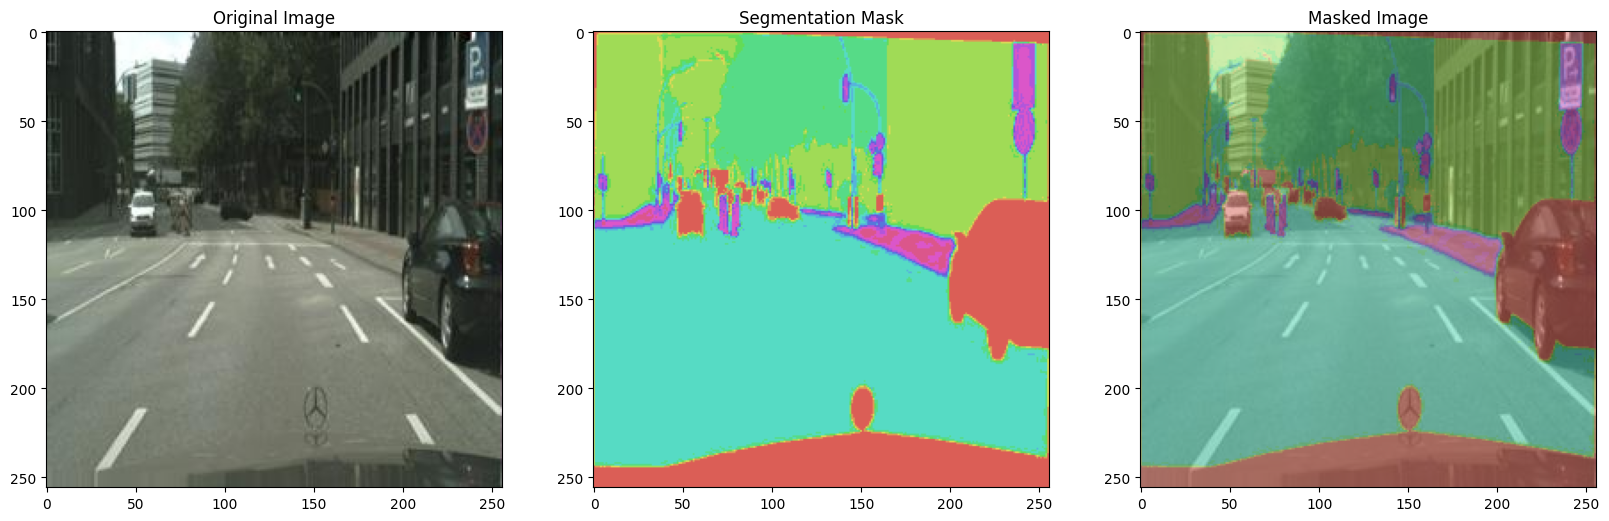

In [11]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plot.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plot.show()

## Segmentation model VGG19 dan Fully Convolutional Network

In [12]:
def fcn(vgg19, classes = 13, fcn8 = False, fcn16 = False):
    pool5 = vgg19.get_layer('block5_pool').output 
    pool4 = vgg19.get_layer('block4_pool').output
    pool3 = vgg19.get_layer('block3_pool').output
    
    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)
    
    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)
    
    deconv_7 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8))(add_2)
    
    if fcn8 :
        output_layer = Activation('softmax')(deconv_9)
    elif fcn16 :
        deconv_10 = Conv2DTranspose(classes, kernel_size=(16,16), strides=(16,16))(add_1)
        output_layer = Activation('softmax')(deconv_10)
    else :
        deconv_11 = Conv2DTranspose(classes, kernel_size=(32,32), strides=(32,32))(conv_7)
        output_layer = Activation('softmax')(deconv_11)
    
    model = Model(inputs=vgg19.input, outputs=output_layer)
    return model

In [13]:
vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(width, height, 3))

In [14]:
model = fcn(vgg19, fcn8=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

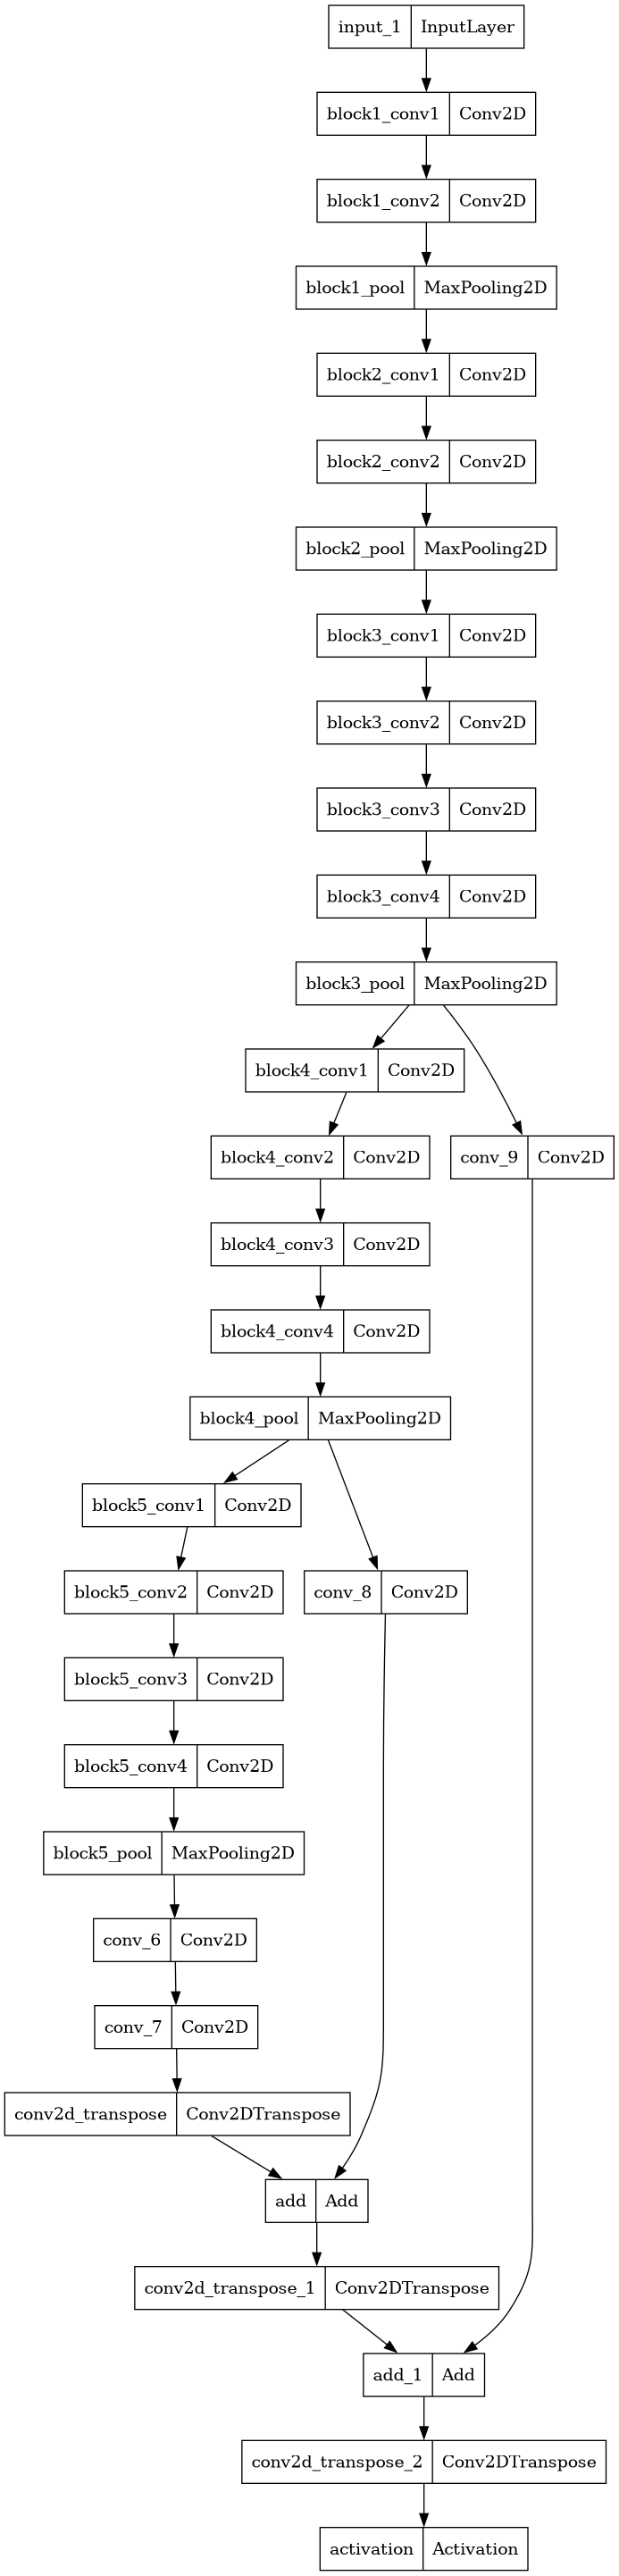

In [15]:
plot_model(model)

## Train model

In [16]:
from tensorflow.keras.optimizers import Adam
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
filepath = "model_vgg19.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [18]:
history = model.fit(train_gen, epochs=10, steps_per_epoch=num_of_training_samples//batch_size,
                       validation_data=val_gen, validation_steps=num_of_testing_samples//batch_size,
                       callbacks=callbacks_list, use_multiprocessing=True)

Epoch 1/10
185/185 [==============================] - ETA: 0s - loss: 7.0456 - accuracy: 0.2525
Epoch 1: val_accuracy improved from -inf to 0.23217, saving model to model_vgg19.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


185/185 [==============================] - 404s 2s/step - loss: 7.0456 - accuracy: 0.2525 - val_loss: 2.3893 - val_accuracy: 0.2322
Epoch 2/10
185/185 [==============================] - ETA: 0s - loss: 2.2905 - accuracy: 0.2250
Epoch 2: val_accuracy improved from 0.23217 to 0.24726, saving model to model_vgg19.h5
185/185 [==============================] - 422s 2s/step - loss: 2.2905 - accuracy: 0.2250 - val_loss: 2.1296 - val_accuracy: 0.2473
Epoch 3/10
185/185 [==============================] - ETA: 0s - loss: 2.0065 - accuracy: 0.2913
Epoch 3: val_accuracy improved from 0.24726 to 0.31719, saving model to model_vgg19.h5
185/185 [==============================] - 443s 2s/step - loss: 2.0065 - accuracy: 0.2913 - val_loss: 1.9341 - val_accuracy: 0.3172
Epoch 4/10
185/185 [==============================] - ETA: 0s - loss: 1.9250 - accuracy: 0.3164
Epoch 4: val_accuracy improved from 0.31719 to 0.32235, saving model to model_vgg19.h5
185/185 [==============================] - 493s 3s/step

## Validasi and Visualisasi Hasil

In [19]:
model.load_weights("model_vgg19.h5")

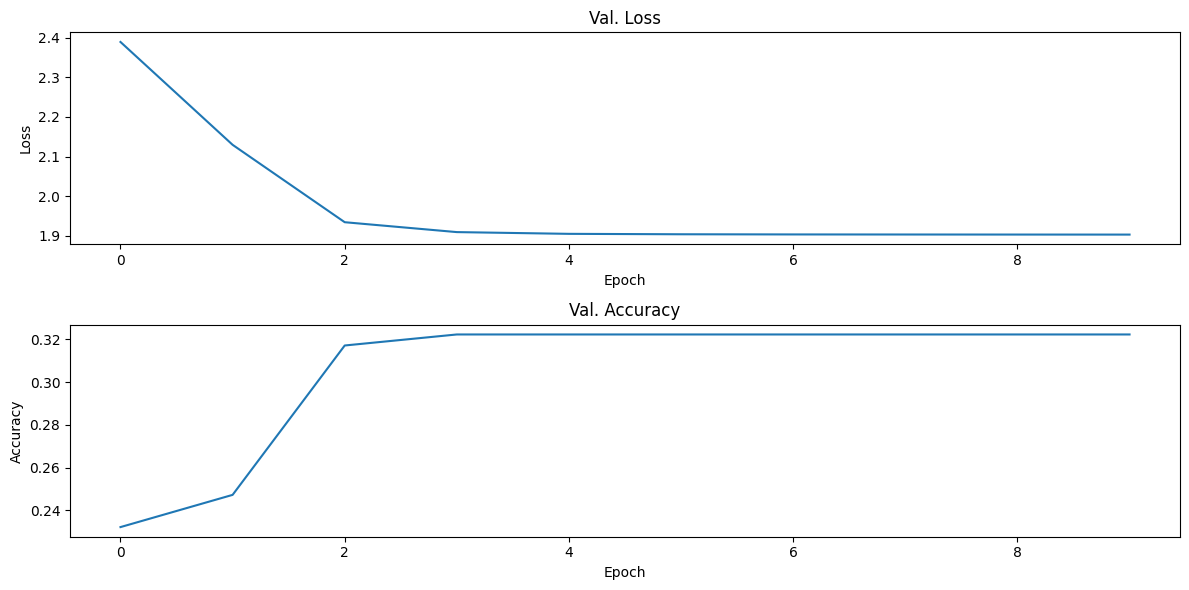

In [20]:
loss = history.history["val_loss"]
acc = history.history["val_accuracy"] #accuracy

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(acc)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

1/1 [==============================] - 1s 714ms/step


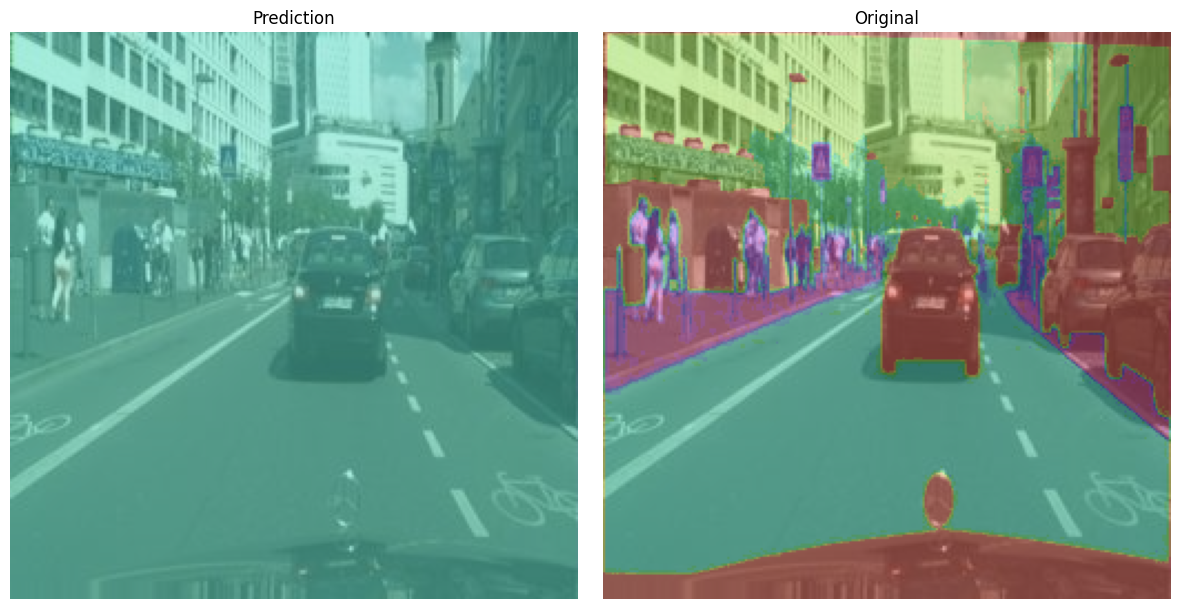

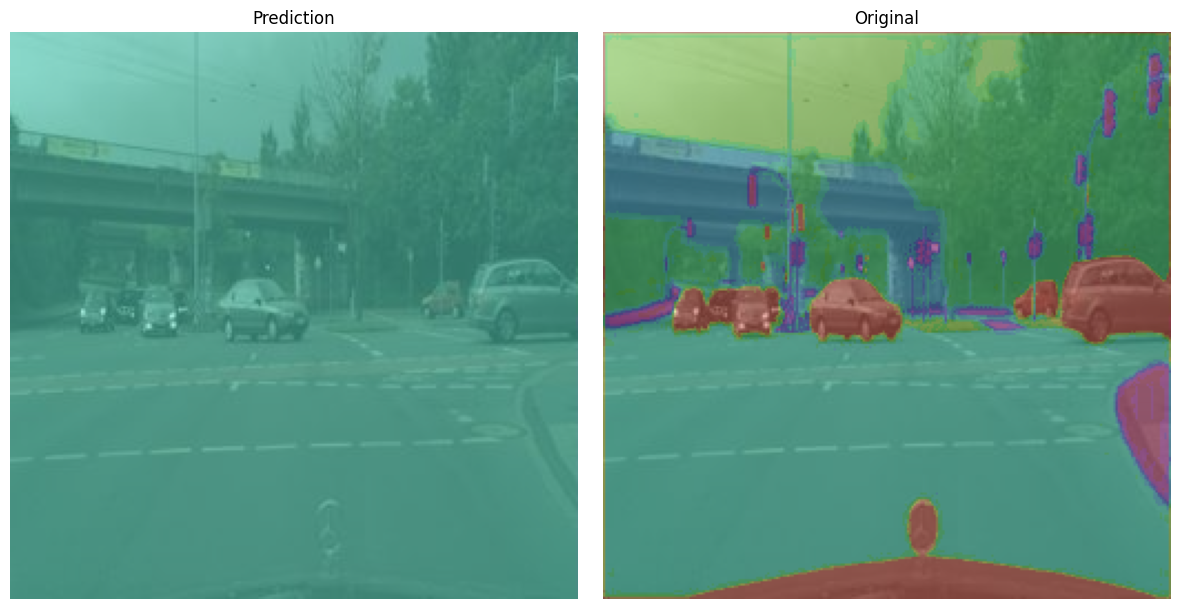

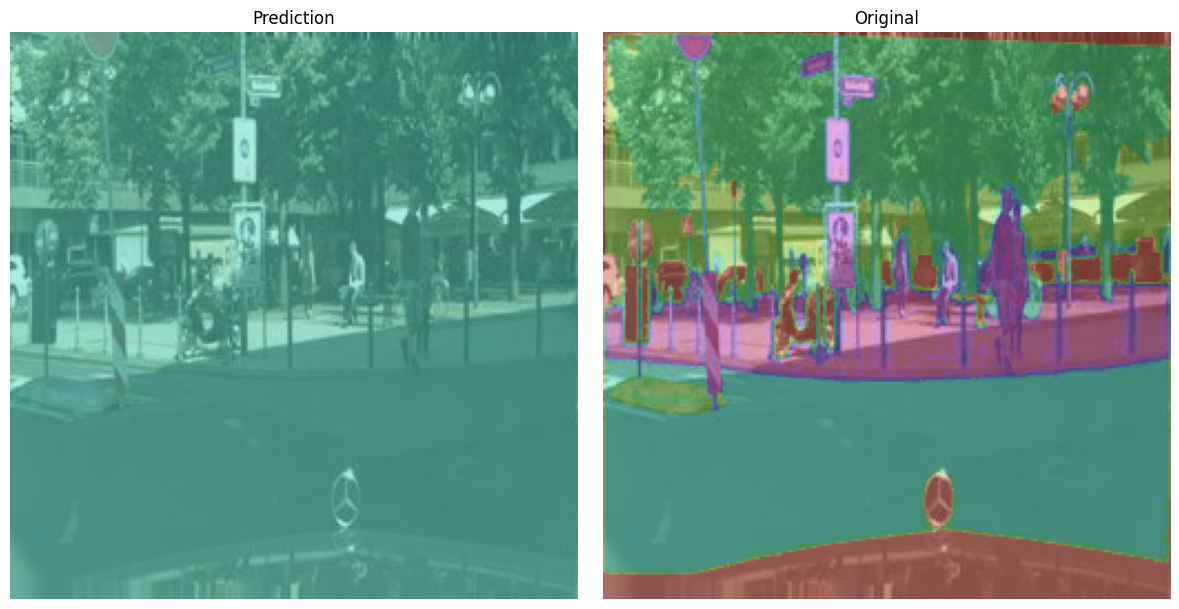

In [21]:
#val_gen = DataGenerator(valid_folder)
max_show = 3
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)
    
    plot.figure(figsize=(12,6))
    plot.subplot(121)
    plot.title("Prediction")
    plot.imshow(predimg)
    plot.axis("off")
    plot.subplot(122)
    plot.title("Original")
    plot.imshow(trueimg)
    plot.axis("off")
    plot.tight_layout()
    plot.savefig("pred_"+str(i)+".png", dpi=150)
    plot.show()

## Save Model

In [22]:
model.save('/kaggle/working/model_vgg19.h5')

In [23]:
!ls -al

total 549992
drwxr-xr-x 3 root root      4096 Dec 19 11:40 .
drwxr-xr-x 5 root root      4096 Dec 19 09:46 ..
drwxr-xr-x 2 root root      4096 Dec 19 09:46 .virtual_documents
-rw-r--r-- 1 root root     54981 Dec 19 11:40 learn.png
-rw-r--r-- 1 root root    163761 Dec 19 10:23 model.png
-rw-r--r-- 1 root root 562280616 Dec 19 11:40 model_vgg19.h5
-rw-r--r-- 1 root root    232579 Dec 19 11:40 pred_0.png
-rw-r--r-- 1 root root    186284 Dec 19 11:40 pred_1.png
-rw-r--r-- 1 root root    248462 Dec 19 11:40 pred_2.png


In [24]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/model.png (deflated 16%)
  adding: kaggle/working/model_vgg19.h5 (deflated 36%)
  adding: kaggle/working/pred_2.png (deflated 6%)
  adding: kaggle/working/pred_0.png (deflated 6%)
  adding: kaggle/working/learn.png (deflated 18%)
  adding: kaggle/working/pred_1.png (deflated 6%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
